In the following, the basic code for making this work is shown and, after that, a set of examples are given.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import constants

sns.set(context="notebook", style="white", palette="colorblind")
%matplotlib inline

from overreact import core, thermo, simulate

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams["figure.dpi"] = 120

## Simple numerical tests

(The example below starts from energy values. Before that, use a reaction scheme for, say, a Michaelis-Menten reaction that has prediction and proposed scheme, against which I can compare results: https://www.beilstein-journals.org/bjoc/articles/6/87)

Now a simple numerical example is due, in the same format as in the other notebook.
I will generate the equations for a Michaelis-Menten like model (same system as in [here](https://en.wikipedia.org/wiki/Petersen_matrix#Example)).

In [3]:
import numpy as np

In [4]:
scheme = core.parse("""
A + 2 B -> TS* -> S
E + S <=> ES -> ES* -> E + P
""")
scheme.compounds, scheme.reactions, scheme.A, scheme.B

(['A', 'B', 'TS*', 'S', 'E', 'ES', 'ES*', 'P'],
 ['A + 2 B -> S', 'E + S -> ES', 'ES -> E + S', 'ES -> E + P'],
 array([[-1.,  0.,  0.,  0.],
        [-2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 1., -1.,  1.,  0.],
        [ 0., -1.,  1.,  1.],
        [ 0.,  1., -1., -1.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[-1.,  0.,  0.,  0.],
        [-2.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  1.,  0., -1.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.]]))

What we did here is better than in the other notebook, since a matrix $B$ is now available for us to generate $k$:

In [5]:
T = 298.15
kappa = 1.

delta_gibbs = thermo.get_delta(scheme.B, [0., 1., 10., 5., 1., 1., 7.5, 2.])
K = np.exp(- delta_gibbs / (constants.R * T / (constants.kilo * constants.calorie)))

# This is Eyring's equation
k = kappa * (constants.k * T / constants.h) * K

delta_gibbs, K, k

(array([ 8. , -5. ,  0. ,  6.5]),
 array([1.36760068e-06, 4.62408100e+03, 1.00000000e+00, 1.71975641e-05]),
 array([8.49613440e+06, 2.87268165e+16, 6.21243799e+12, 1.06838801e+08]))

Observe that the reaction rates for equilibria satisfy the equilibrium constants.

In [6]:
# TODO: scipy 1.4+ will support passing args from solve_ivp, but for now let's do something rather mundane here
def dydt(t, y):
    r = k * np.prod(np.power(y, np.where(scheme.A > 0, 0, -scheme.A).T), axis=1)
    return np.dot(scheme.A, r)

array([1.02593073e+00, 5.18614557e-02, 0.00000000e+00, 4.84005706e-07,
       9.97766954e-02, 2.23304612e-04, 0.00000000e+00, 4.73844774e-01])

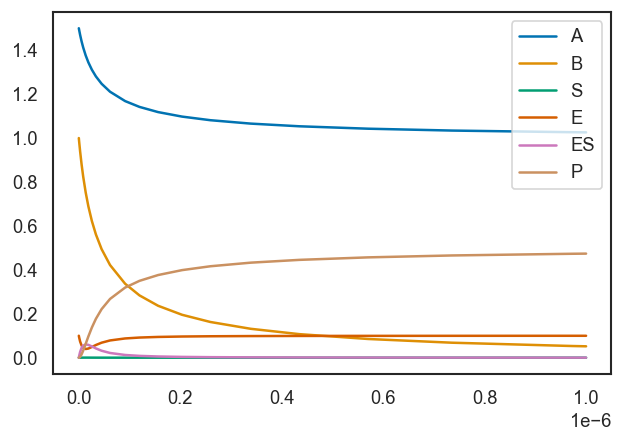

In [7]:
y0 = np.array([1.5, 1., 0., 0., 0.1, 0., 0.0, 0.])
t, y = simulate.get_y(dydt, y0, t_span=[0.0, 1e-6], method="Radau")

for i, compound in enumerate(scheme.compounds):
    if not compound.endswith("*"):
        plt.plot(t, y[i], label=compound)
plt.legend()
y[:, -1]